In [ ]:
!pip install gymnasium

## Libraries

In [ ]:
from posixpath import basename
# import gym
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Enviroment

In [ ]:



I = 0
J = 0

SEED = 186
GRID_SIZE = (6, 6)
def choose_unique_positions(matrix_size, num_positions,start_pos,goal_pos):
    positions = set()

    random.seed(SEED)
    while len(positions) < num_positions:
        row = random.randint(0, matrix_size - 1)
        col = random.randint(0, matrix_size - 1)
        if ((row, col) != start_pos) and ((row, col) != goal_pos) :
            positions.add((row, col))
    return list(positions)

def state_to_index(state, grid_size):
    return state[0] * grid_size[1] + state[1]

def index_to_state(index, grid_size):
    row = index // grid_size[1]
    col = index % grid_size[1]
    return row, col

agent_pose_idxs_list = [0,1,2,6,7,12]
target_pose_idxs_list = [23, 28,29,33,34,35]

np.random.seed(SEED)
agent_idx = np.random.choice(agent_pose_idxs_list, size=1, replace=False)[0]
target_idx = np.random.choice(target_pose_idxs_list, size=1, replace=False)[0]

start_pos =  index_to_state(agent_idx, GRID_SIZE)
goal_pos = index_to_state(target_idx, GRID_SIZE)

obst_pos = choose_unique_positions(matrix_size = 6, num_positions = 8,start_pos = start_pos,goal_pos = goal_pos)

class GridworldEnv2(gym.Env):
    def __init__(self, grid_size=(6, 6), start_position=start_pos, goal_position=goal_pos, obstacles=[]):
        super(GridworldEnv2, self).__init__()

        self.grid_size = grid_size
        self.start_position = start_position
        self.goal_position = goal_position
        self.obstacles = obstacles

        self.action_space = spaces.Discrete(4)  # 4 discrete actions: up, down, left, right
        self.observation_space = spaces.Discrete(np.prod(grid_size))

        self.state = start_position
        self.done = False
        self.action_map = {"down":0, "up":1, "right":2, "left":3}

        self.discount_factor = 0.9
        self.battery = 100
        self.health = 100
        self.internal_crash = False # if battery < 5 or health < 15, this variable ganna be true.
        self.find_goal = False
        self.steps = 0

    def reset(self):
        self.state = self.start_position
        self.battery = 100
        self.health = 100
        self.internal_crash = False
        self.done = False
        self.find_goal = False
        self.steps = 0
        return self.state

    def action_uncertainty(self, action:int,prob_actual_act = 0.8, prob_static = 0.1, prob_reverse_act = 0.1):
        return action
        beam = random.uniform(0, 1)
        if beam < prob_actual_act:
            return action
        elif (beam >= prob_actual_act ) and (beam <= prob_actual_act + prob_static ):
            return None
        else:
            if action == 0:
                action = 1
            elif action == 1:
                action = 0
            elif action == 2:
                action = 3
            elif action == 3:
                action == 2

            return action

    def _battery_decay(self):

        self.battery = self.battery - np.random.normal(.35, np.sqrt(.15))
        if self.battery <= 5:
            self.internal_crash = True
            global I
            I += 1

    def _health_decay(self):
        self.health = self.health - np.random.normal(.2, np.sqrt(.1))
        if self.health<= 15:
            self.internal_crash = True
            global J
            J += 1

    def step(self, action):
        # random.seed(SEED+2)
        action = self.action_uncertainty(action)
        self.steps += 1
        x, y = self.state
        if action == 0:  # Down
            x = min(self.grid_size[0] - 1, x + 1)
        elif action == 1:  # Up
            x = max(0, x - 1)
        elif action == 2:  # Right
            y = min(self.grid_size[1] - 1, y + 1)
        elif action == 3:  # Left
            y = max(0, y - 1)

        if (x, y) in self.obstacles:
            x, y = self.state
            #self._battery_decay()
            self._health_decay()
            if self.internal_crash:
                self.done = True
            reward = self.reward_function(obstacle_true = True)

        else:
            self.state = (x, y)
            self._battery_decay()
            if self.internal_crash:
                self.done = True
            reward = self.reward_function()

        # Check if the agent reached the goal
        if self.state == self.goal_position:
            self.done = True
            self.find_goal = True
        return self.state, reward, self.done, {"find_goal":self.find_goal, "steps":self.steps}

    def reward_function(self, obstacle_true = False):
        if self.state == self.goal_position:
            return np.random.normal(25, 5)
        elif obstacle_true:
            return np.random.normal(-1, 0.5)
        else:
            return np.random.normal(-0.5, 0.25)

    def render(self):
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if (i, j) == self.state:
                    print("A", end=" ")  # A represents the agent
                elif (i, j) == self.goal_position:
                    print("G", end=" ")  # G represents the goal
                elif (i, j) in self.obstacles:
                    print("X", end=" ")  # X represents obstacles
                else:
                    print(".", end=" ")
            print()


if __name__ == "__main__":
    env = GridworldEnv2(grid_size=(6, 6), start_position=start_pos, goal_position=goal_pos, obstacles=obst_pos)
    state = env.reset()
    env.render()


X . A . . . 
. . X . . . 
. . . . . X 
X . X . X X 
X . . . . . 
. . . . . G 


# Q Learning

In [ ]:

class  Epsilon_Greedy:
    def __init__(self, start_epsilon=1, decay_rate=0.998):
        self.start_epsilon = start_epsilon
        self.decay_rate = decay_rate
        self.epsilon = start_epsilon

    def _epsilon_greedy_action(self, q_values,  episode, episode_max,constant_eps = False):
        if constant_eps == True:
            temp_epsilon = 0.1
        else:
            temp_epsilon = self.epsilon
            self.epsilon = self._epsilon_decay(episode, episode_max)

        if random.uniform(0, 1) < temp_epsilon:
            return random.choice(range(len(q_values)))  # Exploration
        else:
            return np.argmax(q_values)  # Exploitation

    def _epsilon_decay(self, episode, episode_max):

        return self.start_epsilon * (self.decay_rate ** (np.clip(episode, 0, episode_max - 1)))

e_greedy = Epsilon_Greedy()


def decay_learning_rate(episode, initial_lr = 1 , decay_rate= 0.98, min_lr=0.01):
    current_lr = initial_lr * (1 - decay_rate) ** episode
    if current_lr < min_lr:
        current_lr = min_lr
    return current_lr


def q_learning(env, num_episodes=1000, init_lr = 1, discount_factor=0.9, constant_lr = False):
    e_greedy = Epsilon_Greedy()
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    lr = init_lr
    meta_infos = []
    for episode in range(num_episodes):
        state = env.reset()

        done = False
        i = 0
        while not done:
            # Choose action using epsilon-greedy policy
            state_idx = state_to_index(state, GRID_SIZE)
            action = e_greedy._epsilon_greedy_action(q_table[state_idx],episode = episode, episode_max=num_episodes)
            #print(action)
            next_state, reward, done, meta_info = env.step(action)
            # print(env.health)
            #cumulative_rewards[episode] += reward
            next_state_idx = state_to_index(next_state, GRID_SIZE)
            # Update Q-value using the Q-learning update rule
            q_table[state_idx, action] = (1 - lr) * q_table[state_idx, action] + \
                                     lr * (reward + discount_factor * np.max(q_table[next_state_idx]))



            state = next_state

        meta_infos.append(meta_info)
        if constant_lr == False:
            lr = decay_learning_rate(episode= episode, initial_lr = lr)

    return q_table, meta_infos


## Q-Learning (constant LR vs LR decay)

In [ ]:

trials_regret_lr_constant = []
trials_regret_lr_decay =  []
for i in range(10):
    env = GridworldEnv2(grid_size=(6, 6), start_position=start_pos, goal_position=goal_pos, obstacles=obst_pos)
    _ , meta_infos_lr_decay  = q_learning(env)
    env = GridworldEnv2(grid_size=(6, 6), start_position=start_pos, goal_position=goal_pos, obstacles=obst_pos)
    _ , meta_infos_lr_constat  = q_learning(env, init_lr=0.1, constant_lr = True)

    regret_on_step_lr_decay= 8-np.array([item["steps"] for item in meta_infos_lr_decay])
    regret_on_step_lr_constant= 8-np.array([item["steps"] for item in meta_infos_lr_constat])

    #plot_regret(regret_per_episode)
    trials_regret_lr_constant.append(regret_on_step_lr_constant)
    trials_regret_lr_decay.append(regret_on_step_lr_decay)

mean_regret_lr_constant =  np.mean(trials_regret_lr_constant, axis = 0)
mean_regret_lr_decay = np.mean(trials_regret_lr_decay, axis = 0)



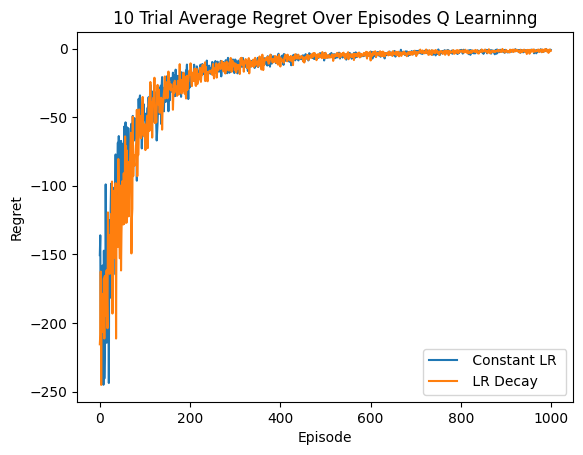

In [ ]:

plt.plot(mean_regret_lr_constant, label = " Constant LR ")
plt.plot(mean_regret_lr_decay, label = " LR Decay" )
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes Q Learninng')
plt.legend()
plt.show()

# Sarsa

In [ ]:

def sarsa(env, num_episodes=1000,init_lr = 1, discount_factor=0.9):
    e_greedy = Epsilon_Greedy()
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    lr = init_lr
    meta_infos = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        state_idx = state_to_index(state, GRID_SIZE)
        action = e_greedy._epsilon_greedy_action(q_table[state_idx],episode = episode, episode_max=num_episodes)
        while not done:
            # Choose action using epsilon-greedy policy
            next_state, reward, done, meta_info = env.step(action)
            next_state_idx = state_to_index(next_state, GRID_SIZE)
            next_action = e_greedy._epsilon_greedy_action(q_table[next_state_idx],episode = episode, episode_max=num_episodes)
            # Update Q-value using the Q-learning update rule
            q_table[state_idx, action] = q_table[state_idx, action] + lr * \
                                     (reward + discount_factor * q_table[next_state_idx, next_action] - q_table[state_idx, action])

            state_idx = next_state_idx
            state = next_state
            action = next_action
        meta_infos.append(meta_info)
        lr = decay_learning_rate(episode)
    return q_table, meta_infos



# Tree Backup-step

In [ ]:
def n_step_tree_backup(env, num_episodes=1000,init_lr = 1, discount_factor=0.9, n=3):
    e_greedy = Epsilon_Greedy()
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    lr = init_lr
    meta_infos = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_states = []
        episode_actions = []
        episode_rewards = []

        while not done:
            # Choose action using epsilon-greedy policy
            state_idx = state_to_index(state, GRID_SIZE)
            action = e_greedy._epsilon_greedy_action(q_table[state_idx],episode = episode, episode_max=num_episodes)
            next_state, reward, done, meta_info = env.step(action)
            episode_states.append(state_idx)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state


        # N-step tree backup
        T = len(episode_states)
        for t in range(T - n + 1):
            G = sum([discount_factor**(i-t-1) * episode_rewards[i] for i in range(t, min(t+n, T))])
            target = G + discount_factor**n * np.max(q_table[episode_states[t+n-1]])
            q_table[episode_states[t], episode_actions[t]] += lr * (target - q_table[episode_states[t], episode_actions[t]])

        meta_infos.append(meta_info)
        lr = decay_learning_rate(episode)

    return q_table, meta_infos


## Compare SARSA & n-step tree backup

In [ ]:
trials_regret_sarsa = []
trials_regret_3_step = []
trials_regret_5_step = []
trials_regret_9_step = []
for i in range(10):
    env = GridworldEnv2(grid_size=(6, 6), start_position=start_pos, goal_position=goal_pos, obstacles=obst_pos)
    _ , meta_infos_sarsa = sarsa(env)
    _ , meta_infos_3_step = n_step_tree_backup(env,n = 3)
    _ , meta_infos_5_step = n_step_tree_backup(env,n = 5)
    _ , meta_infos_9_step = n_step_tree_backup(env,n = 9)

    regret_one_step_sarsa = 8-np.array([item["steps"] for item in meta_infos_sarsa])
    regret_one_step_3_step = 8-np.array([item["steps"] for item in meta_infos_3_step])
    regret_one_step_5_step = 8-np.array([item["steps"] for item in meta_infos_5_step])
    regret_one_step_9_step = 8-np.array([item["steps"] for item in meta_infos_9_step])


    #plot_regret(regret_per_episode)
    trials_regret_sarsa.append(regret_one_step_sarsa)
    trials_regret_3_step.append(regret_one_step_3_step)
    trials_regret_5_step.append(regret_one_step_5_step)
    trials_regret_9_step.append(regret_one_step_9_step)





mean_regret_sarsa = np.mean(trials_regret_sarsa, axis = 0)
mean_regret_3_step = np.mean(trials_regret_3_step, axis = 0)
mean_regret_5_step = np.mean(trials_regret_5_step, axis = 0)
mean_regret_9_step = np.mean(trials_regret_9_step, axis = 0)





## Sarsa vs n-step

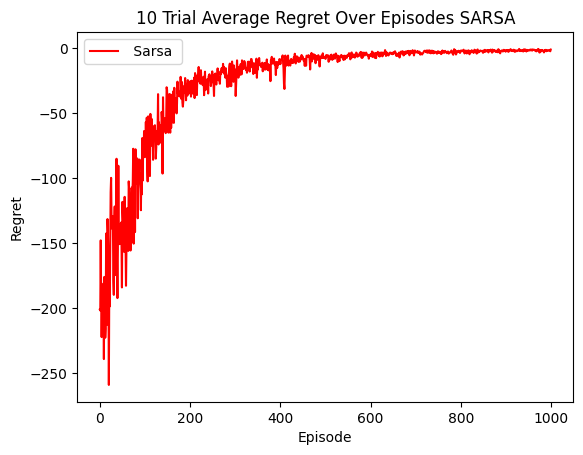

In [ ]:
plt.plot(mean_regret_sarsa, label = " Sarsa ", color = "r")
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes SARSA')
plt.legend()
plt.show()

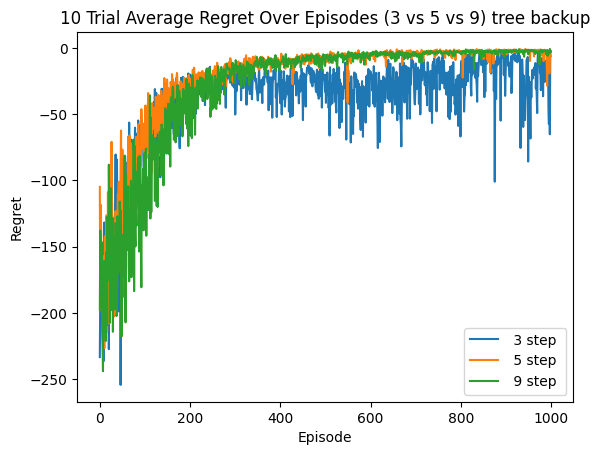

In [ ]:
plt.plot(mean_regret_3_step, label = " 3 step ")
plt.plot(mean_regret_5_step, label = " 5 step ")
plt.plot(mean_regret_9_step, label = " 9 step ")

plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes (3 vs 5 vs 9) tree backup')
plt.legend()
plt.show()

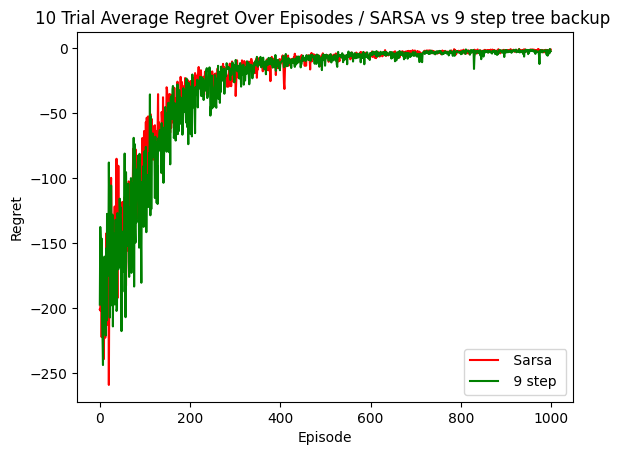

In [ ]:
plt.plot(mean_regret_sarsa, label = " Sarsa ", color ="r" )
plt.plot(mean_regret_9_step, label = " 9 step ", color = "g")
plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes / SARSA vs 9 step tree backup ')
plt.legend()
plt.show()

# On Policy Monte Carlo

In [ ]:
def on_policy_mc(env, num_episodes=1000, discount_factor=0.9, constant_eps= False):
    e_greedy = Epsilon_Greedy()
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    returns_sum = np.zeros_like(q_table)
    returns_count = np.zeros_like(q_table)
    meta_infos = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        episode_states = []
        episode_actions = []
        episode_rewards = []
        while not done:
            # Choose action using epsilon-greedy policy
            state_idx = state_to_index(state, env.grid_size)
            action = e_greedy._epsilon_greedy_action(q_table[state_idx],episode = episode,
                                                     episode_max=num_episodes,
                                                     constant_eps= constant_eps)
            next_state, reward, done, meta_info = env.step(action)
            episode_states.append(state_idx)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state = next_state
        meta_infos.append(meta_info)
        G = 0
        for t in reversed(range(len(episode_states))):
            G = env.discount_factor * G + episode_rewards[t]
            if (episode_states[t], episode_actions[t]) not in zip(episode_states[:t], episode_actions[:t]):
                #returns_sum[episode_states[t], episode_actions[t]] += G
                returns_count[episode_states[t], episode_actions[t]] += 1
                q_table[episode_states[t], episode_actions[t]] += (1/returns_count[episode_states[t], episode_actions[t]])\
                *(G - q_table[episode_states[t], episode_actions[t]] )
    return q_table, meta_infos





In [ ]:
trials_regret_onpolicy_mc_const_eps =  []
trials_regret_onpolicy_mc_decay_eps =  []

for i in range(10):

    _ , meta_infos_onpolicy_mc_decay_eps  = on_policy_mc(env)
    _ , meta_infos_onpolicy_mc_const_eps  = on_policy_mc(env, constant_eps=True)

    regret_on_step_onpolicy_mc_const_eps = 8-np.array([item["steps"] for item in meta_infos_onpolicy_mc_const_eps])
    regret_on_step_onpolicy_mc_decay_eps = 8-np.array([item["steps"] for item in meta_infos_onpolicy_mc_decay_eps])


    #plot_regret(regret_per_episode)
    trials_regret_onpolicy_mc_const_eps.append(regret_on_step_onpolicy_mc_const_eps)
    trials_regret_onpolicy_mc_decay_eps.append(regret_on_step_onpolicy_mc_decay_eps)


mean_regret_onpolicy_mc_const_eps = np.mean(trials_regret_onpolicy_mc_const_eps, axis = 0)
mean_regret_onpolicy_mc_decay_eps = np.mean(trials_regret_onpolicy_mc_decay_eps, axis = 0)


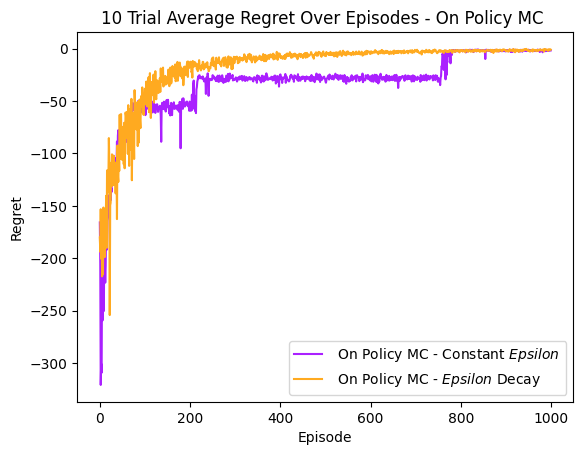

In [ ]:
# plt.plot(mean_regret_sarsa, label = " Sarsa ", color ="r" )
plt.plot(mean_regret_onpolicy_mc_const_eps, label = " On Policy MC - Constant $Epsilon$ ", color = "#AA20FF")
plt.plot(mean_regret_onpolicy_mc_decay_eps, label = " On Policy MC - $Epsilon$ Decay ", color = "#FFAA20")

plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes - On Policy MC ')
plt.legend()
plt.show()

## All in One Frame

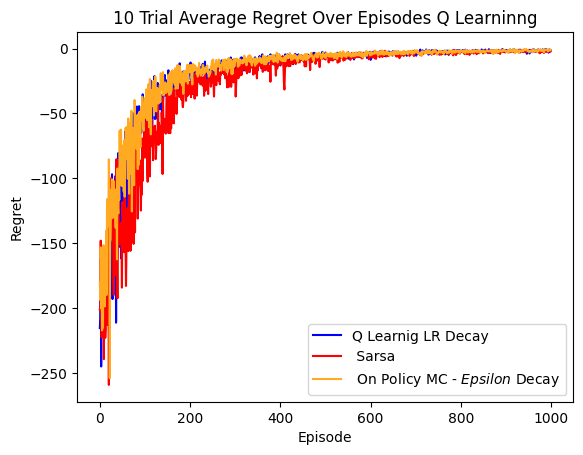

In [ ]:
plt.plot(mean_regret_lr_decay, label = "Q Learnig LR Decay", color= "b" )
plt.plot(mean_regret_sarsa, label = " Sarsa ", color ="r" )
plt.plot(mean_regret_onpolicy_mc_decay_eps, label = " On Policy MC - $Epsilon$ Decay ", color = "#FFAA20")



plt.xlabel('Episode')
plt.ylabel('Regret')
plt.title('10 Trial Average Regret Over Episodes Q Learninng')
plt.legend()
plt.show()